<a href="https://colab.research.google.com/github/Lisankk/Dirisl_Phase2_PJT/blob/Ito_branch/calculate_auuc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import scipy as sp
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [26]:
!pip install japanize_matplotlib
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=b1d5c7c5be9faa72a82b9445e7a3cd339c522d9d1119b74e2e19cf7ce7e05e75
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#csvファイルの読み込み
df = pd.read_csv('/content/drive/MyDrive/abtest_results_for_coupon_sending.csv')
df.head()

,sex,recency,history,mens_product_purchase,womens_product_purchase,area_classification,newbie,channel,segment,visit,conversion,spend
0,男性,6,32908,1,1,地方,1,ウェブ,送付なし,0,0,0
1,男性,9,67583,1,0,地方,1,ウェブ,送付あり,0,0,0
2,女性,9,67507,1,1,地方,1,スマートフォン,送付あり,0,0,0
3,男性,2,10164,0,1,都会,0,ウェブ,送付あり,1,0,0
4,女性,4,24142,0,1,地方,1,複数,送付なし,0,0,0


In [4]:
df["sex"] = df["sex"].map({"男性": 0, "女性": 1})
df["segment"] = df["segment"].map({"送付あり": 0, "送付なし": 1})

In [5]:
df_onehot = pd.get_dummies(df[["area_classification", "channel"]], dtype=int)
df = pd.concat([df, df_onehot], axis=1)
df = df.drop(["area_classification", "channel"], axis=1)
df.head()

,sex,recency,history,mens_product_purchase,womens_product_purchase,newbie,segment,visit,conversion,spend,area_classification_地方,area_classification_郊外,area_classification_都会,channel_ウェブ,channel_スマートフォン,channel_複数
0,0,6,32908,1,1,1,1,0,0,0,1,0,0,1,0,0
1,0,9,67583,1,0,1,0,0,0,0,1,0,0,1,0,0
2,1,9,67507,1,1,1,0,0,0,0,1,0,0,0,1,0
3,0,2,10164,0,1,0,0,1,0,0,0,0,1,1,0,0
4,1,4,24142,0,1,1,1,0,0,0,1,0,0,0,0,1


In [6]:
df_RF = df[["recency", "history", "newbie", "segment", "visit"]]
df_RF

,recency,history,newbie,segment,visit
0,6,32908,1,1,0
1,9,67583,1,0,0
2,9,67507,1,0,0
3,2,10164,0,0,1
4,4,24142,1,1,0
...,...,...,...,...,...
42608,7,8646,0,0,1
42609,10,10554,0,0,1
42610,5,3890,1,0,0
42611,6,2999,1,0,1


**ランダムフォレストの実装に当たってクーポンありとなしのグループに分ける**

In [7]:
df_RF_YesKoupon = df_RF[df_RF["segment"] == 0]
df_RF_NoKoupon = df_RF[df_RF["segment"] == 1]

In [8]:
df_RF_YesKoupon = df_RF_YesKoupon.drop("segment", axis = 1)
df_RF_NoKoupon = df_RF_NoKoupon.drop("segment", axis = 1)



---
以下より、クーポンありモデルについて、交差検証ありのRandom Forestの実装を進めていく。


**交差検証の実装(クーポンあり)**

In [9]:
# 学習モデルを作成
model = RandomForestClassifier(random_state=42)

# 説明変数と目的変数の定義
X_yes_coupon = df_RF_YesKoupon[["recency", "history", "newbie"]]
y_yes_coupon = df_RF_YesKoupon["visit"]

# クロスバリデーションの実行
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_yes_coupon = cross_val_score(model, X_yes_coupon, y_yes_coupon, cv=kf, scoring='roc_auc') # 評価指標にはAUCを使用

print(f'Cross-Validation AUC (各フォールドに対して): {scores_yes_coupon}')
print(f'Cross-Validation AUC (平均): {scores_yes_coupon.mean()}')

Cross-Validation AUC (各フォールドに対して): [0.92122285 0.92361279 0.92581986 0.92480975 0.92297242]
Cross-Validation AUC (平均): 0.9236875351962113


**oof算出処理 (クーポンあり)**

In [10]:
# oof予測値を格納する配列
oof_predictions_yes_coupon = np.zeros(X_yes_coupon.shape[0])

# クロスバリデーションの実行
for train_index, val_index in kf.split(X_yes_coupon):
  X_train_yes_cv, X_val_yes = X_yes_coupon.iloc[train_index], X_yes_coupon.iloc[val_index]
  y_train_yes, y_test_yes = y_yes_coupon.iloc[train_index], y_yes_coupon.iloc[val_index]

  # 学習モデルを作成
  model = RandomForestClassifier(random_state=42)

  # モデル学習
  model.fit(X_train_yes_cv, y_train_yes)

  # oof予測値の保存
  oof_predictions_yes_coupon[val_index] = model.predict_proba(X_val_yes)[:, 1]

# OOFスコア（AUCを使用）を計算
oof_score_yes_coupon = roc_auc_score(y_yes_coupon, oof_predictions_yes_coupon)
print(f'OOF AUC Score: {oof_score_yes_coupon}')

OOF AUC Score: 0.9236210709406577


**評価 (クーポンあり)**

In [11]:
# 交差検証なしの実装の時と同じ方法でデータを分割
X_train_yes, X_test_yes, t_train_yes, t_test_yes = train_test_split(
    df_RF_YesKoupon[["recency", "history", "newbie"]],
    df_RF_YesKoupon["visit"],
    test_size=0.3,
    random_state=0
)

AUC (CVあり): 0.9232549033139061
正解率 (CVあり): 83.78%
適合率 (CVあり): 87.86%
再現率 (CVあり): 85.99%
F1 (CVあり): 86.91%


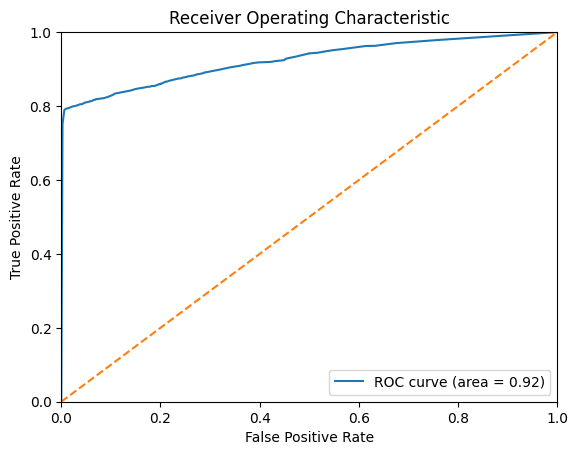

In [12]:
# 訓練データ全体でモデルを再訓練
model.fit(X_train_yes, t_train_yes)

# テストデータでの予測
test_predictions_yes_coupon = model.predict_proba(X_test_yes)[:, 1]

# テストデータでのAUC評価
test_auc_yes_coupon = roc_auc_score(t_test_yes, test_predictions_yes_coupon)
print(f'AUC (CVあり): {test_auc_yes_coupon}')

# テストデータでのその他の評価指標の計算
test_preds_binary = model.predict(X_test_yes)
score_cv = accuracy_score(t_test_yes, test_preds_binary)
precision_cv = precision_score(t_test_yes, test_preds_binary)
recall_cv = recall_score(t_test_yes, test_preds_binary)
f1_cv = f1_score(t_test_yes, test_preds_binary)
print(f"正解率 (CVあり): {score_cv * 100:.2f}%")
print(f"適合率 (CVあり): {precision_cv * 100:.2f}%")
print(f"再現率 (CVあり): {recall_cv * 100:.2f}%")
print(f"F1 (CVあり): {f1_cv * 100:.2f}%")

# ROC曲線の描画
fpr, tpr, thresholds = roc_curve(t_test_yes, test_predictions_yes_coupon)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % test_auc_yes_coupon)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

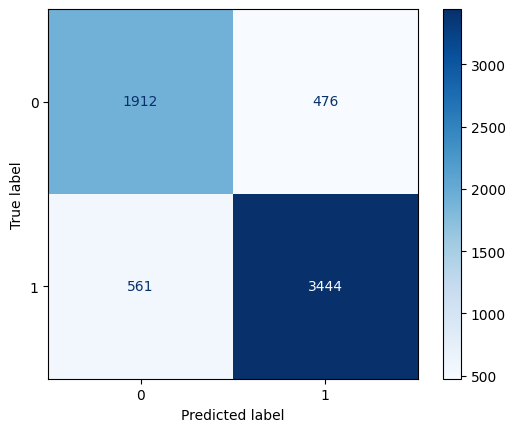

In [13]:
# 混同行列
cm = confusion_matrix(t_test_yes, test_preds_binary)
cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
cmp.plot(cmap=plt.cm.Blues)


---
クーポンなしモデルについて、交差検証ありの実装

**交差検証の実装(クーポンなし)**



In [14]:
# 学習モデルを作成
model = RandomForestClassifier(random_state=42)

# 説明変数と目的変数の定義
X = df_RF_NoKoupon[["recency", "history", "newbie"]]
y = df_RF_NoKoupon["visit"]

# クロスバリデーションの実行
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc') # 評価指標にはAUCを使用

print(f'Cross validation scores: {scores.mean()}')

Cross validation scores: 0.6433457078408645


**oof算出処理の実装**



In [15]:

Z = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X):
  # oof予測値を格納する配列
  oof_predictions = np.zeros(X.shape[0])
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_test = y.iloc[train_index], y.iloc[val_index]

  # 学習モデルを作成
  model = RandomForestClassifier(random_state=42)

  # モデル学習
  model.fit(X_train, y_train)

  # oof予測値の保存
  oof_predictions = model.predict_proba(X_val)[:, 1]
  oof_predictions = pd.DataFrame(oof_predictions)


  # OOFスコア（AUCを使用）を計算
  oof_score = roc_auc_score(y_test, oof_predictions)
  print(f'OOF AUC Score: {oof_score}')

  # OOF予測値を保存
  Z.append(oof_score)


OOF AUC Score: 0.642559856723534
OOF AUC Score: 0.6382034370928705
OOF AUC Score: 0.6573899787743648
OOF AUC Score: 0.6434249367245574
OOF AUC Score: 0.6351503298889958


In [16]:
pd.DataFrame(Z).mean()

,0
0,0.643346


In [17]:
X.shape[0]

21306

**評価**

**クーポンなしの実装**

AUC (CVあり): 0.6398533085145779
正解率 (CVあり): 63.89%
適合率 (CVあり): 44.19%
再現率 (CVあり): 40.04%
F1 (CVあり): 42.01%


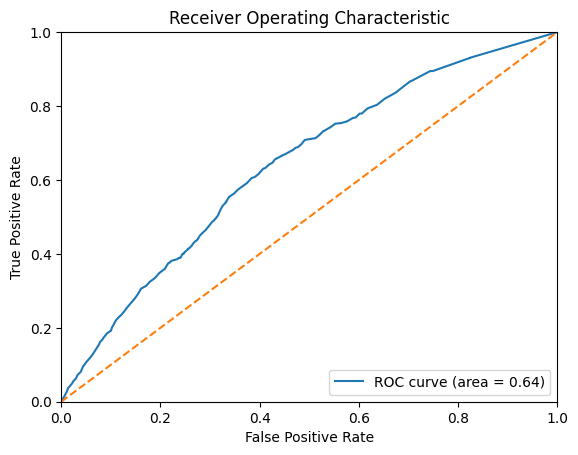

In [18]:
# 交差検証なしの実装の時と同じ方法でデータを分割
X_train, X_test, t_train, t_test = train_test_split(
    df_RF_NoKoupon[["recency", "history", "newbie"]],
    df_RF_NoKoupon["visit"],
    test_size=0.3,
    random_state=0
)

# 訓練データ全体でモデルを再訓練
model.fit(X_train, t_train)

# テストデータでの予測
test_predictions = model.predict_proba(X_test)[:, 1]

# テストデータでのAUC評価
test_auc = roc_auc_score(t_test, test_predictions)
print(f'AUC (CVあり): {test_auc}')

# テストデータでのその他の評価指標の計算
test_preds_binary = model.predict(X_test)
score_cv = accuracy_score(t_test, test_preds_binary)
precision_cv = precision_score(t_test, test_preds_binary)
recall_cv = recall_score(t_test, test_preds_binary)
f1_cv = f1_score(t_test, test_preds_binary)
print(f"正解率 (CVあり): {score_cv * 100:.2f}%")
print(f"適合率 (CVあり): {precision_cv * 100:.2f}%")
print(f"再現率 (CVあり): {recall_cv * 100:.2f}%")
print(f"F1 (CVあり): {f1_cv * 100:.2f}%")

# ROC曲線の描画
fpr, tpr, thresholds = roc_curve(t_test, test_predictions)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % test_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**AUUCの算出**

In [20]:
# クーポンありのデータでモデルをトレーニング
model_yes = RandomForestClassifier(random_state=42)
model_yes.fit(X_train_yes, t_train_yes)

# クーポンなしのデータでモデルをトレーニング
model_no = RandomForestClassifier(random_state=42)
model_no.fit(X_train, t_train)

## X_test_yesとX_testを結合、t_test_yesとt_testを結合
X_test_combined = pd.concat([X_test_yes, X_test]).reset_index(drop=True)
t_test_combined = pd.concat([t_test_yes, t_test]).reset_index(drop=True)

# クーポンありモデルの予測
test_predictions_yes = model_yes.predict_proba(X_test_combined)[:, 1]

# クーポンなしモデルの予測
test_predictions_no = model_no.predict_proba(X_test_combined)[:, 1]

# Uplift Scoreの計算
uplift_scores = test_predictions_yes - test_predictions_no

必要なデータの準備

In [21]:
# クーポンあり・なしのフラグを作成
visit_flg = t_test_combined
treat_flg = pd.concat([pd.Series(np.ones(len(t_test_yes))), pd.Series(np.zeros(len(t_test)))]).reset_index(drop=True)

# 検証データの準備
test_data = pd.DataFrame({
    'cv_flg': visit_flg,
    'treat_flg': treat_flg,
    'uplift_score': uplift_scores
})

# uplift score が大きい順に検証データを並び替え
result = test_data.sort_values(by='uplift_score', ascending=False).reset_index(drop=True)

AUUCの計算およびuplift curveの描画

In [22]:
# lift の算出
result['treat_num_cumsum'] = result['treat_flg'].cumsum()
result['control_num_cumsum'] = (1 - result['treat_flg']).cumsum()
result['treat_cv_cumsum'] = (result['treat_flg'] * result['cv_flg']).cumsum()
result['control_cv_cumsum'] = ((1 - result['treat_flg']) * result['cv_flg']).cumsum()
result['treat_cvr'] = (result['treat_cv_cumsum'] / result['treat_num_cumsum']).fillna(0)
result['control_cvr'] = (result['control_cv_cumsum'] / result['control_num_cumsum']).fillna(0)
result['lift'] = (result['treat_cvr'] - result['control_cvr']) * result['treat_num_cumsum']
result['base_line'] = result.index * result['lift'][len(result.index) - 1] / len(result.index)

# AUUC の算出
auuc = (result['lift'] - result['base_line']).sum() / len(result['lift'])
print('AUUC = {:.2f}'.format(auuc))

AUUC = 635.39


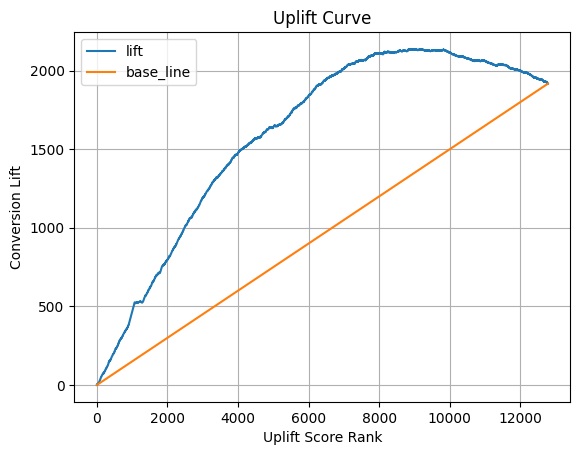

In [23]:
# uplift curveの描画
result.plot(y=['lift', 'base_line'])
plt.xlabel('Uplift Score Rank')
plt.ylabel('Conversion Lift')
plt.title('Uplift Curve')
plt.grid(True)
plt.show()

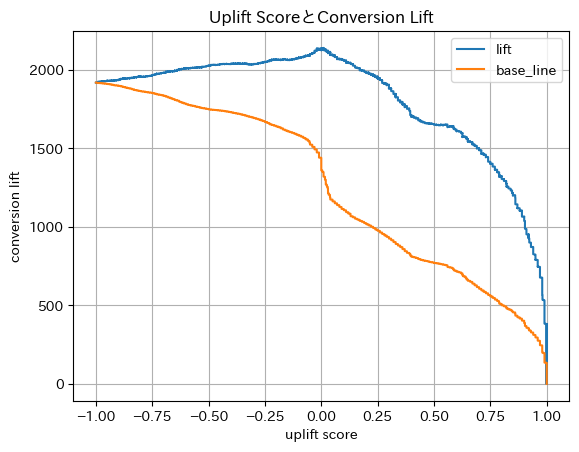

In [27]:
# uplift score × conversion lift のグラフの描画
result.plot(x='uplift_score', y=['lift','base_line'])
plt.xlabel('uplift score')
plt.ylabel('conversion lift')
plt.title('Uplift ScoreとConversion Lift')
plt.grid(True)
plt.show()

conversion率のパーセンタイルの分布の可視化

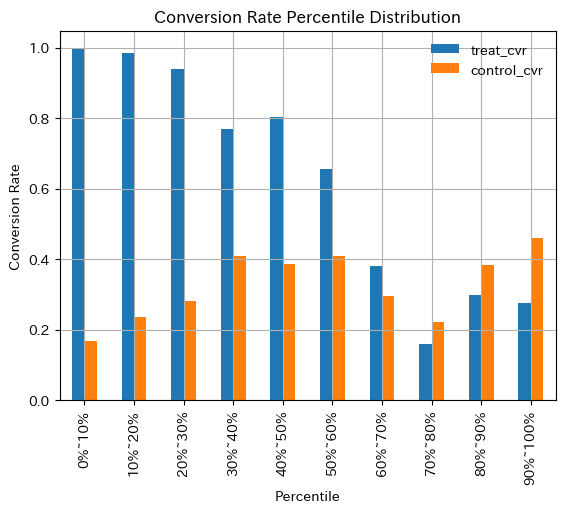

In [29]:
# コンバージョン率のパーセンタイル分布の計算とプロット
result_list = list(zip(result['cv_flg'], result['treat_flg'], result['uplift_score']))
result_list.sort(key=lambda row: row[2], reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))
for n in range(10):
    start = int(n * len(result_list) / 10)
    end = int((n + 1) * len(result_list) / 10) - 1
    quantiled_result = result_list[start:end]

    # 介入群と対照群のユーザー数をカウント
    treat_uu = list(map(lambda item: item[1], quantiled_result)).count(1)
    control_uu = list(map(lambda item: item[1], quantiled_result)).count(0)

    # 介入群と対照群のコンバージョン数 (visit) をカウント
    treat_cv = [item[0] for item in quantiled_result if item[1] == 1].count(1)
    control_cv = [item[0] for item in quantiled_result if item[1] == 0].count(1)

    # 介入群と対照群のコンバージョン率 (visit率) を計算
    treat_cvr = treat_cv / treat_uu if treat_uu > 0 else 0
    control_cvr = control_cv / control_uu if control_uu > 0 else 0
    label = '{}%~{}%'.format(n * 10, (n + 1) * 10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel('Percentile')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate Percentile Distribution')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 10})
plt.grid(True)
plt.show()